In [1]:
import numpy as np
import h5py, os, imageio
import matplotlib.pyplot as plt
from util_Matt import Util
from scipy.optimize import curve_fit


In [2]:
from Module_diagnostic_functions import *

In [3]:
###### read data
dir_out = 'output/'
fnames = ['flat_mirror.h5', '1.01nm_heat_bump_corr.h5', '3.03nm_heat_bump_corr.h5']
labels = ['flat', '1.01 nm_corr', '3.03 nm_corr']

mirror_x = []
mirror_y = []
mirror_h = []

axis_x = []
axis_y = []
axis_z = []

slice_x = []
slice_y = []

for fname in fnames:
    with h5py.File(dir_out+fname, 'r') as f:
        mirror_x.append(f['lens_x'][:])
        mirror_y.append(f['lens_y'][:])
        mirror_h.append(f['lens_h'][:])
        axis_x.append(f['axis_x'][:])
        axis_y.append(f['axis_y'][:])
        axis_z.append(f['axis_z'][:])
        slice_x.append(f['slice_x'][:])
        slice_y.append(f['slice_y'][:])


RMS height error: 0.0pm, Strehl ratio: 1.0
RMS height error: 4.59pm, Strehl ratio: 0.952
RMS height error: 13.78pm, Strehl ratio: 0.643


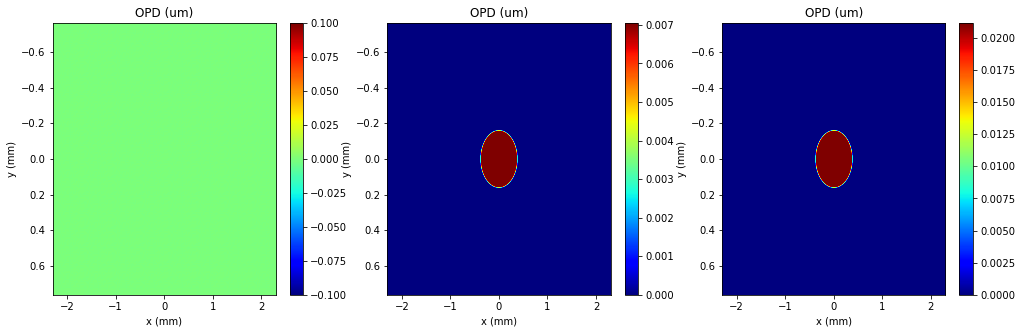

In [4]:
###### Strehl ratio
theta = np.deg2rad(15)
fwhm_on_mir = 250.81e-6
labels = []

plt.figure(figsize=(len(fnames)*5+2,5))
for i in range(len(fnames)):
    xnew_mir = mirror_x[i]
    ynew_mir = mirror_y[i]
    h_new = mirror_h[i]
    E = 9481
    wavelength = 4.135667696e-15 * 299792458/E

    # choose aperture
    index_fwhm = ( (xnew_mir*np.sin(theta))**2 + ynew_mir**2 )<= (fwhm_on_mir/2)**2
    OPD = -h_new * 2 * np.sin(theta); OPD[index_fwhm==False] = 0
    
    plt.subplot(1,len(fnames),i+1)
    plt.imshow(OPD*1e6, cmap='jet',
              extent = [xnew_mir.min()*1e3, xnew_mir.max()*1e3, ynew_mir.max()*1e3, ynew_mir.min()*1e3])
    plt.axis('tight'); plt.colorbar()
    plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.title('OPD (um)')
    d_phase = 2*np.pi*OPD/wavelength
    S = np.abs(np.mean(np.exp(1j*d_phase[index_fwhm])))**2
    h_error = round(np.std(OPD[index_fwhm])*1e12,2)
    label = '{}pm'.format(h_error)
    labels.append(label)
    print('RMS height error: {}pm,'.format(h_error), 'Strehl ratio:', round(S,3))

<ipython-input-5-15e66d3a7e36>:27: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img_x), cmap='jet',
<ipython-input-5-15e66d3a7e36>:32: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(img_y), cmap='jet',


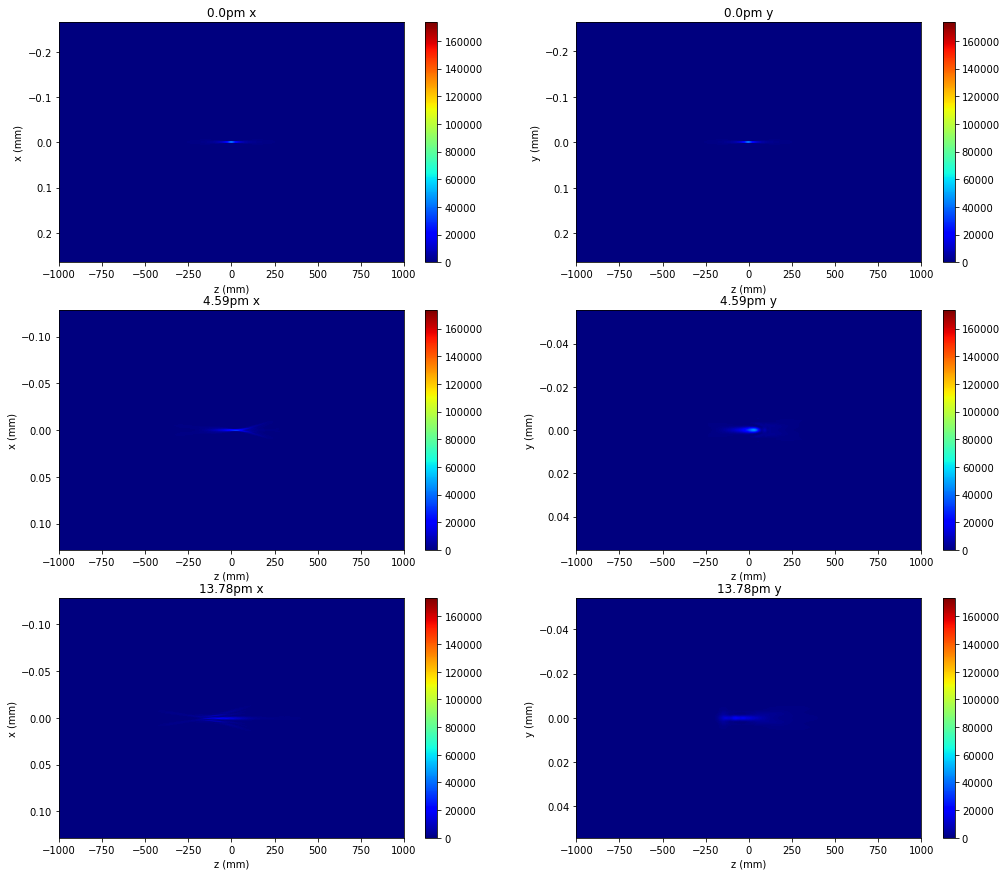

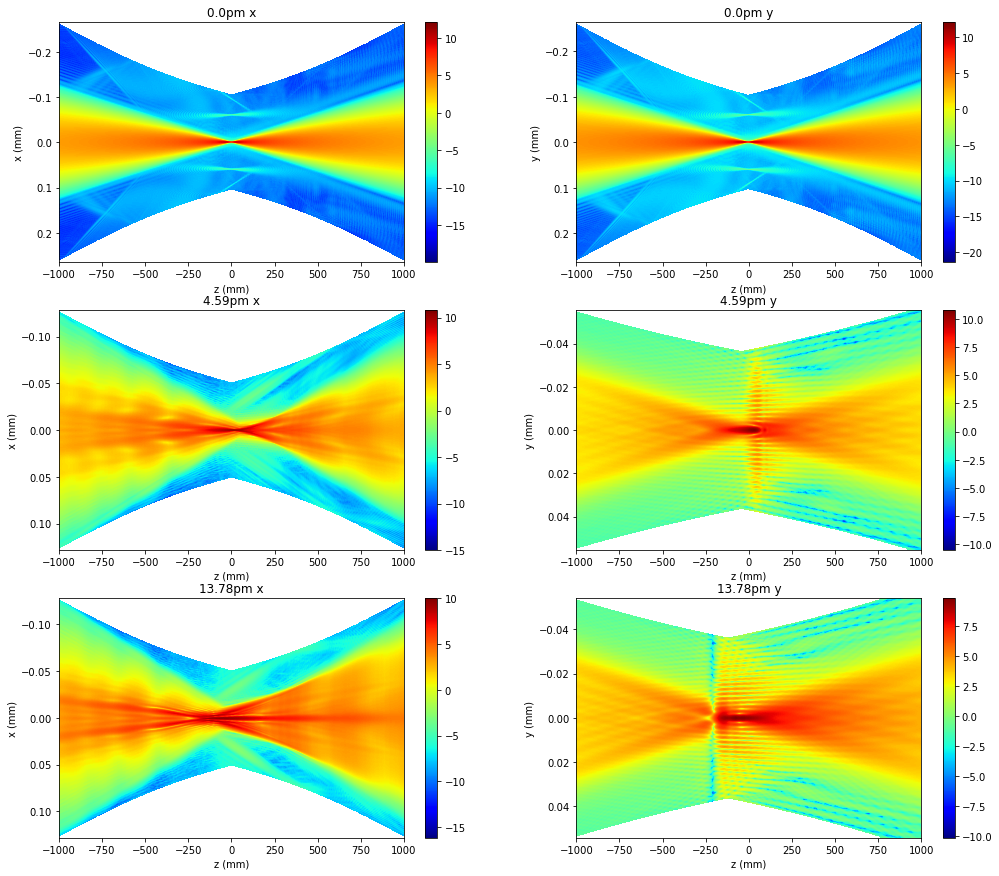

In [5]:
###### overview, linear
plt.figure(figsize=(17,15))
for i in range(len(fnames)):
    img_x = slice_x[i].T; img_y = slice_y[i].T
    x = axis_x[i]*1e3; y = axis_y[i]*1e3; z = axis_z[i]*1e3
    
    plt.subplot(len(fnames),2,2*i+1)
    plt.imshow(img_x, cmap='jet',
              extent = [z.min(), z.max(), x.max(), x.min()])
    plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.title(labels[i]+' x'); plt.axis('tight'); plt.colorbar()
    plt.clim([0, np.max(slice_x)])
    
    plt.subplot(len(fnames),2,2*i+2)
    plt.imshow(img_y, cmap='jet',
              extent = [z.min(), z.max(), y.max(), y.min()])
    plt.xlabel('z (mm)'); plt.ylabel('y (mm)'); plt.title(labels[i]+' y'); plt.axis('tight'); plt.colorbar()
    plt.clim([0, np.max(slice_y)])
plt.savefig(dir_out+'side_view_corr_linear.png', transparent=True)

###### overview, log
plt.figure(figsize=(17,15))
for i in range(len(fnames)):
    img_x = slice_x[i].T; img_y = slice_y[i].T
    x = axis_x[i]*1e3; y = axis_y[i]*1e3; z = axis_z[i]*1e3
    
    plt.subplot(len(fnames),2,2*i+1)
    plt.imshow(np.log(img_x), cmap='jet',
              extent = [z.min(), z.max(), x.max(), x.min()])
    plt.xlabel('z (mm)'); plt.ylabel('x (mm)'); plt.title(labels[i]+' x'); plt.axis('tight'); plt.colorbar()
    
    plt.subplot(len(fnames),2,2*i+2)
    plt.imshow(np.log(img_y), cmap='jet',
              extent = [z.min(), z.max(), y.max(), y.min()])
    plt.xlabel('z (mm)'); plt.ylabel('y (mm)'); plt.title(labels[i]+' y'); plt.axis('tight'); plt.colorbar()
plt.savefig(dir_out+'side_view_corr_log.png', transparent=True)


0.0pm, focus max intensity, x: z=-2.0mm, y: z=-2.0mm
4.59pm, focus max intensity, x: z=28.0mm, y: z=28.0mm
13.78pm, focus max intensity, x: z=-74.0mm, y: z=-72.0mm


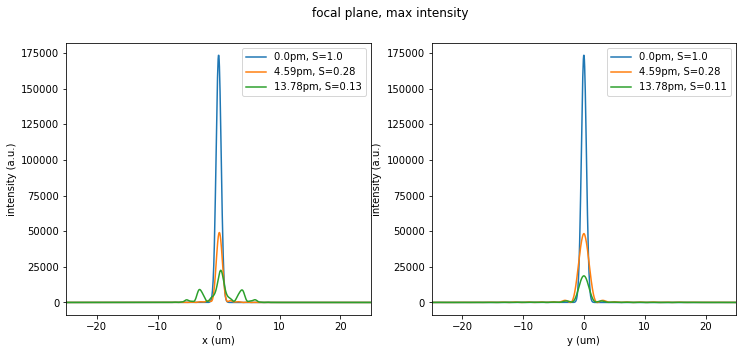

In [6]:
###### find focal plane
fig1 = plt.figure(figsize=(12,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

int_list_x = []
int_list_y = []

focus_x_max_intensity = []
focus_y_max_intensity = []

range_x = 50e-6
range_y = range_x

for i in range(len(fnames)):
    # data
    x = axis_x[i]*1e6; y = axis_y[i]*1e6; z = axis_z[i]*1e3
    nx = x.size; ny = y.size; nz = z.size
    int_x = slice_x[i]; int_y = slice_y[i]; label1 = labels[i]; label2 = label1
    
    ## focal plane (maximum intensity)
#     index_x = np.argmax(int_x[:,np.abs(x)<=1].sum(axis=1))
#     index_y = np.argmax(int_y[:,np.abs(y)<=1].sum(axis=1))
    index_x = np.amax(int_x, axis=1).argmax()
    index_y = np.amax(int_y, axis=1).argmax()
    focus_x_max_intensity.append(index_x)
    focus_y_max_intensity.append(index_y)
    
    line_x = int_x[index_x]
    line_y = int_y[index_y]
    
    int_list_x.append(line_x.max())
    int_list_y.append(line_y.max())
    label1 += ', S={}'.format(round(int_list_x[i]/int_list_x[0],2))
    label2 += ', S={}'.format(round(int_list_y[i]/int_list_y[0],2))
    
    # plots
    ax1.plot(x, line_x, label=label1)
    ax2.plot(y, line_y, label=label2)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('intensity (a.u.)')
ax1.legend()
ax1.set_xlim([-range_x/2*1e6, range_x/2*1e6])

ax2.set_xlabel('y (um)')
ax2.set_ylabel('intensity (a.u.)')
ax2.legend()
ax2.set_xlim([-range_y/2*1e6, range_y/2*1e6])

fig1.suptitle('focal plane, max intensity')

for i, name in enumerate(labels):
    print('{}, focus max intensity, x: z={}mm, y: z={}mm'.format(name, round(z[focus_x_max_intensity][i],2), round(z[focus_y_max_intensity][i],2)))
plt.savefig(dir_out+'Strehl_Ratio_max_corr.png', transparent=True)

In [7]:
def calc_index_intensity_percentile(x, percentile=90):
    nx = x.size
    i_step = int(nx/40)
    total_intensity = x.sum()
    i_start = 0; i_fin = int(nx/2)
    # coarse range
    for i in range(20):
        ii = i*i_step+1
        regional_intensity = x[ii:-ii].sum()
        intensity_ratio = regional_intensity/total_intensity
        if intensity_ratio >= percentile/100:
            i_start = ii
        else:
            i_fin = ii
            break
    for i in np.arange(i_start, i_fin):
        regional_intensity = x[i:-i].sum()
        intensity_ratio = regional_intensity/total_intensity
        if intensity_ratio >= percentile/100:
            continue
        else:
            return int(i-1)

def calc_focus_percentile(x_list, percentile=90):
    boundaries = []
    for i, x in enumerate(x_list):
        i_boundary = calc_index_intensity_percentile(x, percentile=percentile)
        if i_boundary == None: i_boundary = 0
        boundaries.append(i_boundary)
    return np.array(boundaries)


0.0pm, focus 90 percentile, x: z=-6.0mm, y: z=-6.0mm
4.59pm, focus 90 percentile, x: z=22.0mm, y: z=4.0mm
13.78pm, focus 90 percentile, x: z=-128.0mm, y: z=-40.0mm


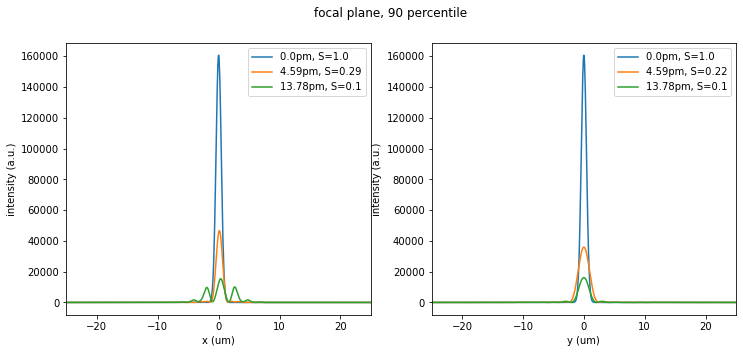

In [8]:
fig2 = plt.figure(figsize=(12,5))
ax3 = fig2.add_subplot(1,2,1)
ax4 = fig2.add_subplot(1,2,2)

int_list_x = []
int_list_y = []

focus_x_90_percentile = []
focus_y_90_percentile = []

for i in range(len(fnames)):
    # data
    x = axis_x[i]*1e6; y = axis_y[i]*1e6; z = axis_z[i]*1e3
    nx = x.size; ny = y.size; nz = z.size
    int_x = slice_x[i]; int_y = slice_y[i]; label1 = labels[i]; label2 = label1
    
    ## focal plane (90 percentile)
    index_x = np.argmax(calc_focus_percentile(int_x))
    index_y = np.argmax(calc_focus_percentile(int_y))
    focus_x_90_percentile.append(index_x)
    focus_y_90_percentile.append(index_y)
    
    line_x = int_x[index_x]
    line_y = int_y[index_y]
    
    int_list_x.append(line_x.max())
    int_list_y.append(line_y.max())
    label1 += ', S={}'.format(round(int_list_x[i]/int_list_x[0],2))
    label2 += ', S={}'.format(round(int_list_y[i]/int_list_y[0],2))
    
    # plots
    ax3.plot(x, line_x, label=label1)
    ax4.plot(y, line_y, label=label2)

ax3.set_xlabel('x (um)')
ax3.set_ylabel('intensity (a.u.)')
ax3.legend()
ax3.set_xlim([-range_x/2*1e6, range_x/2*1e6])

ax4.set_xlabel('y (um)')
ax4.set_ylabel('intensity (a.u.)')
ax4.legend()
ax4.set_xlim([-range_y/2*1e6, range_y/2*1e6])

fig2.suptitle('focal plane, 90 percentile')

for i, name in enumerate(labels):
    print('{}, focus 90 percentile, x: z={}mm, y: z={}mm'.format(name, round(z[focus_x_90_percentile][i],2), round(z[focus_y_90_percentile][i],2)))
plt.savefig(dir_out+'Strehl_Ratio_percent_corr.png', transparent=True)

In [9]:
###### beam around focal plane
fCRL=4
delta_d = np.linspace(-fCRL/4,fCRL/4,1001)

for name in fnames:
    # load images
    dirname = 'output/'+name[:-3]+'/'
    images = []
    for figure in os.listdir(dirname):
        if figure.endswith('.png'):
            if figure.startswith('1_input'): continue
            elif figure.startswith('2_before'): continue
            elif figure.startswith('3_before'): continue
        else:
            continue
        images.append(imageio.imread(dirname+figure))
    imageio.mimsave('output/{}.gif'.format(name[:-3]), images)


In [10]:
### target: 4 slices
# slice 1: thermal deformation shape; beam 1-fwhm on mirror
# slice 2: xz; yz plot
# slice 3: xy around focal plane -> intensity ratio
# slice 4: Strehl ratio vs intensity ratio -> engineering specs